In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import altair as alt
from PIL import Image

from gcnSurrogate.models.feastnetSurrogateModel import FeaStNet
from gcnSurrogate.readers.loadConmechGraphs import loadConmechGraphs
from gcnSurrogate.visualization.altTrussViz import plotTruss, interactiveErrorPlot
from gcnSurrogate.util.gcnSurrogateUtil import *

loading from data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_1_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_2_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_3_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_4_7_N_5/
(1306, 896)


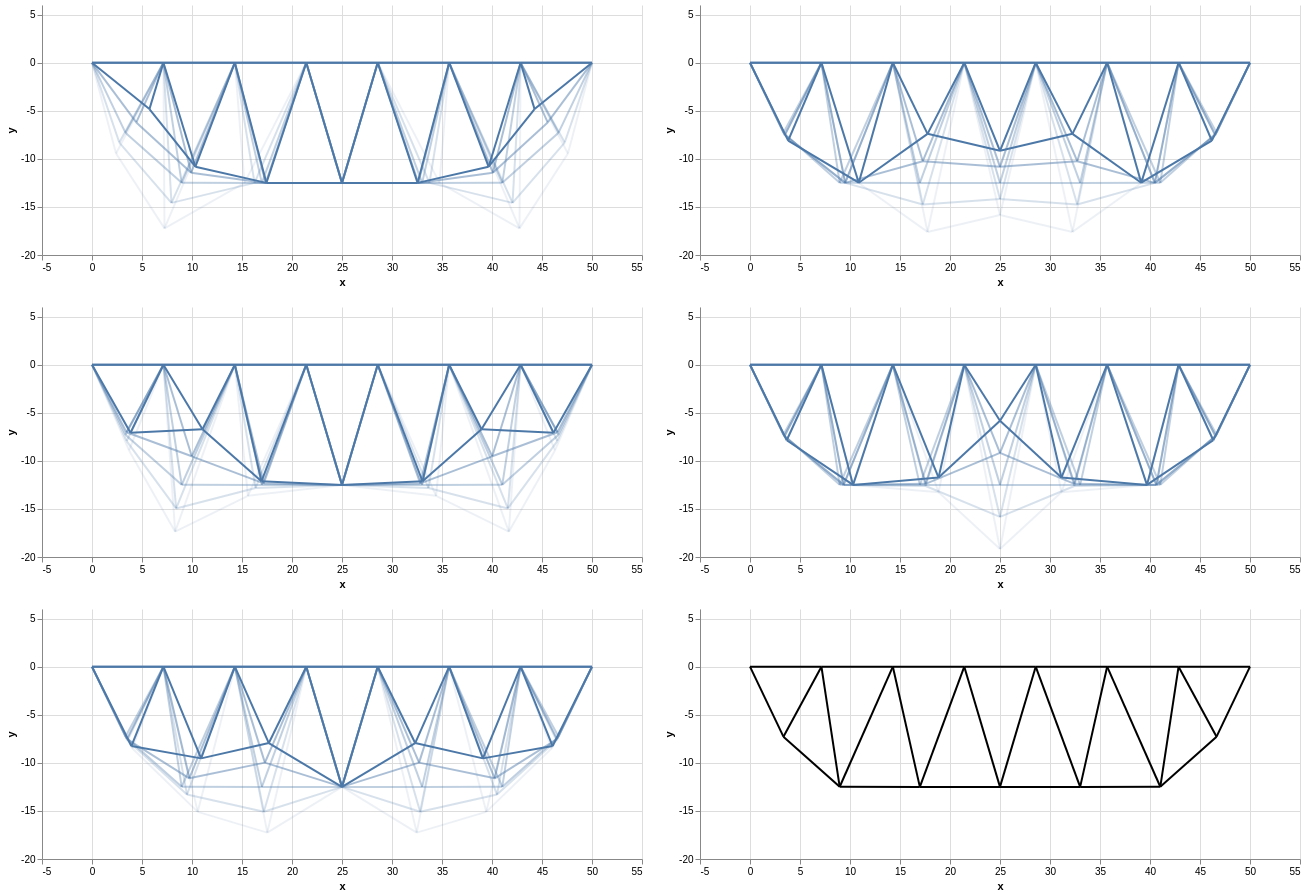

In [2]:
# alt.themes.enable('none')
sweepDirs = glob.glob('data/2D_Truss_v1.3/conmech/param_sweep*/')

sweepPlotList = []
for dataDir in np.sort(sweepDirs):
    print(f'loading from {dataDir}')
    allGraphs = loadConmechGraphs(dataDir)

    opacities = np.linspace(0.1,0.6,5)
    opacities[-1] = 1
    plotList = [plotTruss(g, withoutConfigure=True, lineOpacity=o, domX=[-5,55], domY=[-20,5]) for g,o in zip(allGraphs, opacities)]
    sweepPlot = alt.layer(*plotList)
    sweepPlotList.append(sweepPlot)
    
nomDesign = plotTruss(allGraphs[2], withoutConfigure=True, domX=[-5,55], domY=[-20,5], baseColor='#000000')
    
col0 = alt.vconcat(*sweepPlotList[:3])
col1 = alt.vconcat(*sweepPlotList[3:],nomDesign)
finalChart = alt.hconcat(col0, col1, background='white').configure_view(strokeOpacity=0)

# convert to image
tempFile = 'figures/TEMP.png'
finalChart.save(tempFile)
img = Image.open(tempFile)
print(img.size)
img

In [3]:
dpi = 500 # dots per inch
picW = 3.5625 # inches
imageWidth = dpi*picW
imageWidth

1781.25

(648, 292)


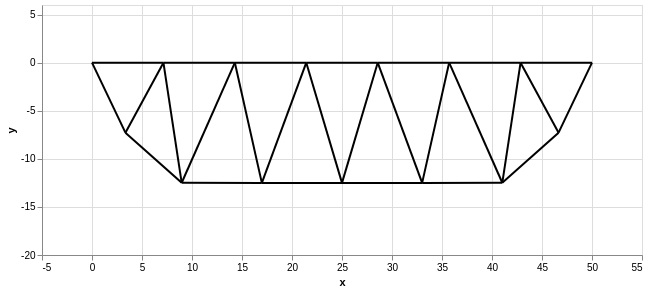

In [9]:
nomDesign = plotTruss(allGraphs[2], withoutConfigure=True, domX=[-5,55], domY=[-20,5], baseColor='#000000', width=600)
nomDesign.save(tempFile)
img = Image.open(tempFile)
print(img.size)
img

In [5]:
from vega_datasets import data
cars = data.cars()

a = alt.Chart(cars).mark_point().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color='Origin',
)

b = alt.hconcat(a,a).properties(width=300)
b

SchemaValidationError: Invalid specification

        altair.vegalite.v4.api.Chart, validating 'required'

        'data' is a required property
        

alt.HConcatChart(...)